<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/APTOS_EYEPACS_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS

In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move
from google.colab import drive

import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
class KaggleJSONFile:
  def __init__(self, folder_path:str):
    self.__folder_location = folder_path
    self.__filename = 'kaggle.json'
    self.__destination_path = '/root/.kaggle'

  def setup(self):
    p_orig = os.path.join(self.__folder_location, self.__filename)
    p_dest = os.path.join(self.__destination_path, self.__filename)

    os.mkdir(self.__destination_path)
    copy(p_orig, p_dest)

    !chmod 600 {p_dest}


In [ ]:
k = KaggleJSONFile('/gdrive/MyDrive/Kaggle_keys')
k.setup()

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 9.51G/9.51G [07:29<00:00, 22.5MB/s]
100% 9.51G/9.51G [07:29<00:00, 22.7MB/s]
100% 6.04G/6.04G [04:48<00:00, 24.6MB/s]
100% 6.04G/6.04G [04:48<00:00, 22.5MB/s]


In [ ]:
zipfiles = [f for f in os.listdir('/content') if '.zip' in f]

def unpack(filename:str):
  f = os.path.join('/content', filename)

  unpack_archive(
      filename = f,
      extract_dir='/content'
  )

  return os.path.join('/content',filename.split('.')[0])

dataset_dirs = [unpack(z) for z in zipfiles]

In [ ]:
train_csv_files = [f for f in os.listdir('/content') if '.csv' in f and 'train' in f]
dataframes = [pd.read_csv(csv) for csv in train_csv_files]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.jpeg', '.png']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

classes = range(5)
orig_ds = pd.concat(dataframes)
orig_ds.reset_index(inplace=True)
orig_ds.iloc[0,:]

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


,image,level
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


index               0
image    10_left.jpeg
level               0
Name: 0, dtype: object

level
0    27607
1     2808
2     6287
3     1065
4     1003
Name: image, dtype: int64

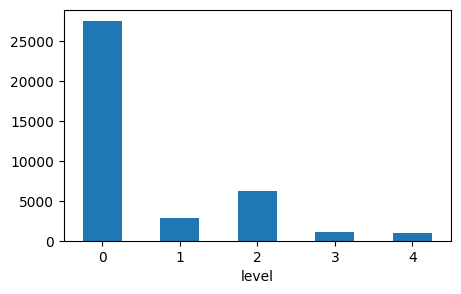

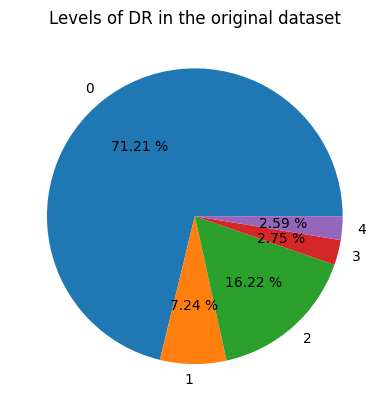

In [ ]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

dfp = orig_ds.pivot_table(
    index='level',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
plt.savefig(img_path)
plt.show()

level
0    1000
1    1000
2    1000
3    1000
4    1000
Name: image, dtype: int64

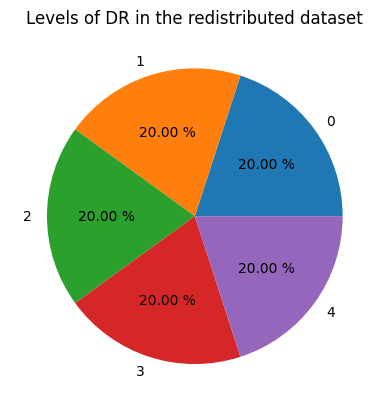

In [ ]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [ ]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

level
0    883
1    905
2    895
3    900
4    917
Name: image, dtype: int64

,image,level
8097,10159_right.jpeg,3
30047,38039_right.jpeg,3
22434,28318_left.jpeg,0
37559,aa6673241154.png,4
37378,a00b4cb250a7.png,1


level
0    61
1    43
2    57
3    48
4    41
Name: image, dtype: int64

,image,level
4792,6017_left.jpeg,4
3076,3808_right.jpeg,2
34650,43805_left.jpeg,2
15180,19018_left.jpeg,3
21997,27747_right.jpeg,2


level
0    56
1    52
2    48
3    52
4    42
Name: image, dtype: int64

,image,level
18433,23237_right.jpeg,0
14855,18605_left.jpeg,0
27360,34646_right.jpeg,2
16437,20608_right.jpeg,0
25702,32542_right.jpeg,0


In [ ]:
path_dict = {p:os.listdir(p)
              for p in ['/content/train_images', '/content/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

{'/content/train_images': ['628b581aa905.png',
  '9785805af1b8.png',
  '7e4019ac7f5a.png',
  '87295c5fa1cc.png',
  '247e98aba610.png',
  'da0a1043abf7.png',
  '73e83a07a16d.png',
  'd0926ed2c8e5.png',
  '31452ad8808c.png',
  'c94f37085d0f.png',
  '3c311c9109b0.png',
  '8688f3d0fcaf.png',
  '7c2f820a6425.png',
  'b9519abce0c1.png',
  '1ab3f1c71a5f.png',
  '762d6e5d5068.png',
  '78937523f7a8.png',
  '269b44e628eb.png',
  '5e52c9fe676f.png',
  '705f508d1e42.png',
  '3bf2deaa5ef0.png',
  'e16fc934069f.png',
  '9985375d709f.png',
  '0d0a21fd354f.png',
  '5a179c123fd8.png',
  'd8404680bba6.png',
  '2b4c7b5f1f1e.png',
  'b8297a2291f5.png',
  '5cbe88914a72.png',
  '1a90fad9ffa2.png',
  '1c3a6b4449e9.png',
  '0304bedad8fe.png',
  '53ddae6a619e.png',
  '82088c6734e6.png',
  '4c635a01593d.png',
  '9837048b85dc.png',
  '0cb6b898389f.png',
  '3a1d3ce00f0c.png',
  '9568eb7e9c08.png',
  'c6d4e4a3bd4c.png',
  'aef9016557ca.png',
  '5b0e53f53ef3.png',
  'd0b132d2c7ec.png',
  '82d364726a58.png',
  '05e9

In [ ]:
splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    print(datapoint['image'])
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])
    move(orig_path, dest_path)

10159_right.jpeg
38039_right.jpeg
28318_left.jpeg
aa6673241154.png
a00b4cb250a7.png
28392_left.jpeg
23532_right.jpeg
43493_right.jpeg
844_right.jpeg
5789_right.jpeg
25385_left.jpeg
37114_left.jpeg
35587_right.jpeg
2223_left.jpeg
32031_right.jpeg
30146_left.jpeg
15351_right.jpeg
17375_left.jpeg
23554_left.jpeg
39134_right.jpeg
1a7e3356b39c.png
16134_right.jpeg
84a72e15b23c.png
60e269e3e188.png
35609_left.jpeg
17152_right.jpeg
30675_right.jpeg
7b49041cbf17.png
4b618537d52f.png
12108_right.jpeg
7722_right.jpeg
9404_right.jpeg
32247_left.jpeg
32214_right.jpeg
4148_right.jpeg
35873_left.jpeg
33836_right.jpeg
b3d135bd3bb5.png
15941_right.jpeg
65e120143825.png
25758_right.jpeg
3655_left.jpeg
40284_left.jpeg
39747_right.jpeg
43839_right.jpeg
40405_left.jpeg
38825_right.jpeg
0243404e8a00.png
1639_right.jpeg
41255_left.jpeg
7d3835e4e63a.png
39111_right.jpeg
25650_left.jpeg
27295_left.jpeg
25138_left.jpeg
24914_left.jpeg
5105_right.jpeg
24910_right.jpeg
23736_left.jpeg
33432_left.jpeg
31461_right

In [ ]:
# MobileNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode
## Load Data


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))
## Training the model



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and vdation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.MobileNet_V3_Large_Weights.DEFAULT
warmup_epochs = 20
training_epochs = warmup_epochs * 5
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')


model_ft = models.mobilenet_v3_large(weights=model_weights)
num_ftrs = model_ft.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


display(model_ft)
### Train and evaluate




# for param in model_ft.features.parameters():
#     param.requires_grad = False
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=warmup_epochs)

# for param in model_ft.features.parameters():
#     param.requires_grad = True
MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=training_epochs)
torch.save(model_ft.state_dict(), MODEL_PATH)

visualize_model(model_ft)
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)